#### Analyses of BERT learnt based on high-order frequency distributions

In [2]:
from vocab_mismatch_utils import *
from data_formatter_utils import *
from datasets import DatasetDict
from datasets import Dataset
from datasets import load_dataset
import transformers
import pandas as pd
import operator
from collections import OrderedDict
from tqdm import tqdm, trange

import collections
import os
import unicodedata
from typing import List, Optional, Tuple

from transformers.tokenization_utils import PreTrainedTokenizer, _is_control, _is_punctuation, _is_whitespace
from transformers.utils import logging
import torch
logger = logging.get_logger(__name__)
import numpy as np
import copy
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 
from word_forms.word_forms import get_word_forms

seed = 42
# set seeds again at start
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

from functools import partial

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
font = {'family' : 'Times New Roman',
        'size'   : 15}
plt.rc('font', **font)

import math
import seaborn as sb

import transformers
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    EvalPrediction,
    HfArgumentParser,
    PretrainedConfig,
    Trainer,
    TrainingArguments,
    default_data_collator,
    set_seed,
    EarlyStoppingCallback
)
from transformers.trainer_utils import is_main_process, EvaluationStrategy
from tabulate import tabulate

In [3]:
# task setups
task_name = "sst3"
num_labels = 3
FILENAME_CONFIG = {
    "sst3" : "sst-tenary"
}

#### First-order frequency and label correlations

In [4]:
# let us corrupt SST3 in the same way as before
train_df = pd.read_csv(os.path.join(external_output_dirname, FILENAME_CONFIG[task_name], 
                                    f"{FILENAME_CONFIG[task_name]}-train.tsv"), 
                       delimiter="\t")
eval_df = pd.read_csv(os.path.join(external_output_dirname, FILENAME_CONFIG[task_name], 
                                   f"{FILENAME_CONFIG[task_name]}-dev.tsv"), 
                      delimiter="\t")
test_df = pd.read_csv(os.path.join(external_output_dirname, FILENAME_CONFIG[task_name], 
                                   f"{FILENAME_CONFIG[task_name]}-test.tsv"), 
                      delimiter="\t")

train_df = Dataset.from_pandas(train_df)
eval_df = Dataset.from_pandas(eval_df)
test_df = Dataset.from_pandas(test_df)

In [7]:
modified_basic_tokenizer = ModifiedBasicTokenizer()
label_vocab_map = {}
token_frequency_map = {} # overwrite this everytime for a new dataset
for i, example in enumerate(train_df):
    if i % 10000 == 0 and i != 0:
        print(f"processing #{i} example...")
    original_sentence = example['text']
    label = example['label']
    if len(original_sentence.strip()) != 0:
        tokens = modified_basic_tokenizer.tokenize(original_sentence)
        if label not in label_vocab_map.keys():
            label_vocab_map[label] = tokens
        else:
            for t in tokens:
                label_vocab_map[label].append(t)
        for t in tokens:
            if t in token_frequency_map.keys():
                token_frequency_map[t] = token_frequency_map[t] + 1
            else:
                token_frequency_map[t] = 1
task_token_frequency_map = sorted(token_frequency_map.items(), key=operator.itemgetter(1), reverse=True)
task_token_frequency_map = OrderedDict(task_token_frequency_map)

processing #10000 example...
processing #20000 example...
processing #30000 example...
processing #40000 example...
processing #50000 example...
processing #60000 example...
processing #70000 example...
processing #80000 example...
processing #90000 example...
processing #100000 example...
processing #110000 example...
processing #120000 example...
processing #130000 example...
processing #140000 example...
processing #150000 example...


In [10]:
freq_set = set([])
for k, v in task_token_frequency_map.items():
    freq_set.add(v)
freq_set = list(freq_set)
freq_set.sort()
freq_bucket = np.logspace(math.log(freq_set[0], 10), math.log(freq_set[-1], 10), 25, endpoint=True)
freq_bucket = freq_bucket[:-1]
freq_bucket = [math.ceil(n) for n in freq_bucket]
# finally the bucket is a map between freq and bucket number
def find_bucket_number(freq, freq_bucket):
    for i in range(len(freq_bucket)):
        if freq > freq_bucket[i]:
            continue
        else:
            return i+1
    return len(freq_bucket)

freq_bucket_map = {}
for freq in freq_set:
    bucket_num = find_bucket_number(freq, freq_bucket)
    freq_bucket_map[freq] = bucket_num
    
# only looking at words that are unique to each label, otherwise long-tail dist dominate!
label_token_freq_bucket_map = {}
for k, v in label_vocab_map.items():
    freq_counts = []
    for t in v:
        freq_counts.append(freq_bucket_map[task_token_frequency_map[t]])
    label_token_freq_bucket_map[k] = freq_counts
    
# have to take samples in order to remove the bias
min_len = 99999999
for k, v in label_token_freq_bucket_map.items():
    if len(v) < min_len:
        min_len = len(v)
sampled_label_buckets = {}
for k, v in label_token_freq_bucket_map.items():
    sampled_label_buckets[k] = random.sample(v, k=min_len)

quantitive results

In [14]:
# PMI of frequency bucket for each label

# p_label
p_label_sum = sum(list(collections.Counter(train_df["label"]).values()))
p_label = [v/p_label_sum for v in list(collections.Counter(train_df["label"]).values())]
label = list(collections.Counter(train_df["label"]).keys())
p_label = dict(zip(label, p_label))

# p_bucket
p_bucket = {}
p_bucket_sum = 0
for i in range(0, num_labels):
    for b in label_token_freq_bucket_map[i]:
        if b in p_bucket.keys():
            p_bucket[b] += 1
        else:
            p_bucket[b] = 1
        p_bucket_sum += 1
for k, v in p_bucket.items():
    p_bucket[k] = v/p_bucket_sum
    
# p_label_bucket
p_label_bucket = {}
for i in range(0, num_labels):
    p_label_bucket[i] = {}
    for b in label_token_freq_bucket_map[i]:
        if b in p_label_bucket[i].keys():
            p_label_bucket[i][b] += 1
        else:
            p_label_bucket[i][b] = 1
    for k, v in p_label_bucket[i].items():
        p_label_bucket[i][k] = (v/p_bucket_sum)/(p_bucket[k]*p_label[i])
        
sorted_p_label_buckets = []
for i in range(0, num_labels):
    sorted_p_label_bucket = sorted(p_label_bucket[i].items(), key=operator.itemgetter(1),reverse=True)
    sorted_p_label_buckets.append(sorted_p_label_bucket)

In [15]:
# get how many examples containing different buckets
label_bucket_example_count_map = {}
for i, example in enumerate(train_df):
    if i % 10000 == 0 and i != 0:
        print(f"processing #{i} example...")
    original_sentence = example['text']
    label = example['label']
    if len(original_sentence.strip()) != 0:
        tokens = modified_basic_tokenizer.tokenize(original_sentence)
        if label not in label_bucket_example_count_map.keys():
            label_bucket_example_count_map[label] = {}
        buckets = set([])
        for t in tokens:
            bucket = freq_bucket_map[task_token_frequency_map[t]]
            buckets.add(bucket)
        for b in buckets:
            if b not in label_bucket_example_count_map[label].keys():
                label_bucket_example_count_map[label][b] = 1
            else:
                label_bucket_example_count_map[label][b] += 1

for k, v in label_bucket_example_count_map.items():
    count_example = collections.Counter(train_df["label"])[k]
    for bucket, count in label_bucket_example_count_map[k].items():
        label_bucket_example_count_map[k][bucket] = count/count_example

processing #10000 example...
processing #20000 example...
processing #30000 example...
processing #40000 example...
processing #50000 example...
processing #60000 example...
processing #70000 example...
processing #80000 example...
processing #90000 example...
processing #100000 example...
processing #110000 example...
processing #120000 example...
processing #130000 example...
processing #140000 example...
processing #150000 example...


In [16]:
# get the stats table for different labels
# print(tabulate([['Alice', 24], ['Bob', 19]], headers=['label', 'Age']))
headers = []
for i in range(0, num_labels):
    headers += [f"label_{i}_pmi", f"label_{i}_prob"]
top_k = 5
lines = []
for i in range(top_k):
    line = []
    for j in range(0, num_labels):
        pmi_bucket = sorted_p_label_buckets[j][i][0]
        prob = label_bucket_example_count_map[j][pmi_bucket]
        line.append(f"bucket[#{pmi_bucket}]")
        line.append(round(prob, 4))
    lines.append(line)
print(tabulate(lines, headers=headers))

label_0_pmi      label_0_prob  label_1_pmi      label_1_prob  label_2_pmi      label_2_prob
-------------  --------------  -------------  --------------  -------------  --------------
bucket[#20]            0.2779  bucket[#21]            0.2852  bucket[#1]             0.0011
bucket[#19]            0.3646  bucket[#13]            0.347   bucket[#2]             0.0106
bucket[#22]            0.33    bucket[#12]            0.3436  bucket[#3]             0.014
bucket[#18]            0.2748  bucket[#14]            0.3096  bucket[#4]             0.0847
bucket[#16]            0.3376  bucket[#22]            0.2894  bucket[#5]             0.1182


qualitative results

[[27, 451, 556, 4372], [33, 496, 734, 4658], [92, 891, 1180, 7640]]


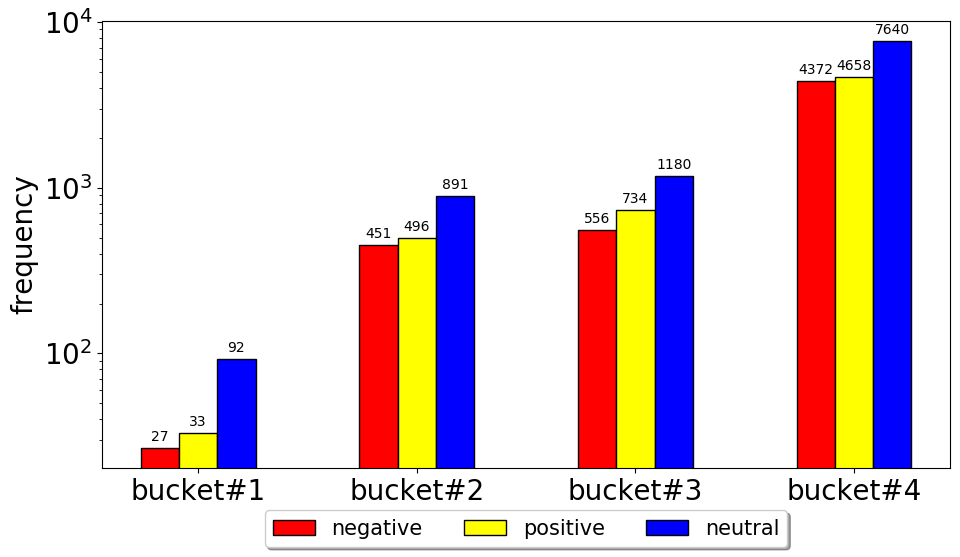

In [63]:
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
plt.style.use("default")
font = {'family' : 'Times New Roman',
        'size'   : 20}
plt.rc('font', **font)

count_to_display = 4
groupby_names = [f"bucket#{i+1}" for i in range(0, count_to_display)]
from itertools import groupby
counts_all = []
for k, v in label_token_freq_bucket_map.items():
    counter_k = collections.Counter(label_token_freq_bucket_map[k])
    counts = []
    for i in range(1, count_to_display+1):
        counts.append(counter_k[i])
    counts_all.append(counts)
groups = counts_all
group_names = ['negative', 'positive', 'neutral']

x = np.array([0, 2, 4, 6])  # the label
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width, groups[0], width, label=group_names[0], edgecolor='black', color="red")
rects2 = ax.bar(x, groups[1], width, label=group_names[1], edgecolor='black', color="yellow")
rects3 = ax.bar(x + width, groups[2], width, label=group_names[2], edgecolor='black', color="blue")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('frequency')
ax.set_yscale('log')
ax.set_xticks(x)
ax.set_xticklabels(groupby_names)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2),
      ncol=3, fancybox=True, shadow=True, fontsize=15)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.0f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

# plt.title("", fontsize=15, pad=10)

# plt.ylim(0,1)
plt.show()

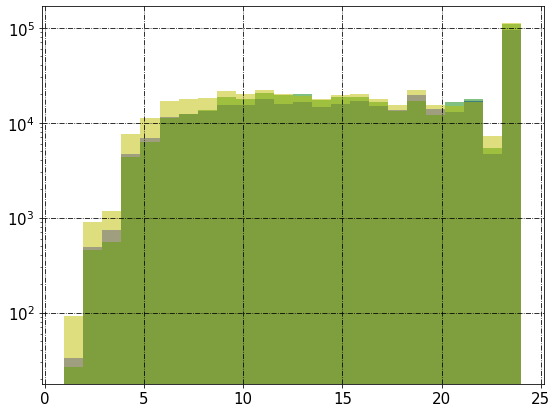

In [27]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
g1 = ax.hist(label_token_freq_bucket_map[0], bins=len(freq_bucket), facecolor='b', alpha = 0.5)
g2 = ax.hist(label_token_freq_bucket_map[1], bins=len(freq_bucket), facecolor='g', alpha = 0.5)
g3 = ax.hist(label_token_freq_bucket_map[2], bins=len(freq_bucket), facecolor='y', alpha = 0.5)
plt.grid(True)
plt.grid(color='black', linestyle='-.')
import matplotlib.ticker as mtick
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
ax.set_yscale('log')
plt.tight_layout()
plt.show()

#### Second-order frequency and label correlations

In [87]:
label_freq_freq_map = {}
label_freq_freq_map[0] = []
label_freq_freq_map[1] = []
label_freq_freq_map[2] = []

for i, example in enumerate(train_df):
    if i % 10000 == 0 and i != 0:
        print(f"processing #{i} example...")
    original_sentence = example['text']
    label = example['label']
    if len(original_sentence.strip()) != 0:
        tokens = modified_basic_tokenizer.tokenize(original_sentence)
        for i in range(len(tokens)-1):
            for j in range(i+1, len(tokens)):
                t1 = tokens[i]
                t2 = tokens[j]
                freq_tuple = tuple([freq_bucket_map[token_frequency_map[t1]], freq_bucket_map[token_frequency_map[t2]]])
                label_freq_freq_map[label].append(freq_tuple)
                
# have to take samples in order to remove the bias
min_len = min(len(label_freq_freq_map[0]), 
              len(label_freq_freq_map[1]), 
              len(label_freq_freq_map[2]))
freq_freq_bucket_1 = random.sample(label_freq_freq_map[0], k=min_len)
freq_freq_bucket_2 = random.sample(label_freq_freq_map[1], k=min_len)
freq_freq_bucket_3 = random.sample(label_freq_freq_map[2], k=min_len)

processing #10000 example...
processing #20000 example...
processing #30000 example...
processing #40000 example...
processing #50000 example...
processing #60000 example...
processing #70000 example...
processing #80000 example...
processing #90000 example...
processing #100000 example...
processing #110000 example...
processing #120000 example...
processing #130000 example...
processing #140000 example...
processing #150000 example...


In [88]:
label_freq_freq_bucket_map = {}
label_freq_freq_bucket_map[0] = {}
label_freq_freq_bucket_map[1] = {}
label_freq_freq_bucket_map[2] = {}
for tu in freq_freq_bucket_1:
    if tu in label_freq_freq_bucket_map[0].keys():
        label_freq_freq_bucket_map[0][tu] += 1
    else:
        label_freq_freq_bucket_map[0][tu] = 1

for tu in freq_freq_bucket_2:
    if tu in label_freq_freq_bucket_map[1].keys():
        label_freq_freq_bucket_map[1][tu] += 1
    else:
        label_freq_freq_bucket_map[1][tu] = 1

for tu in freq_freq_bucket_3:
    if tu in label_freq_freq_bucket_map[2].keys():
        label_freq_freq_bucket_map[2][tu] += 1
    else:
        label_freq_freq_bucket_map[2][tu] = 1

In [89]:
# turing freq tuple into a heatmap
label_freq_freq_2d_map = {}
label_freq_freq_2d_map[0] = torch.zeros(len(freq_bucket), len(freq_bucket))
label_freq_freq_2d_map[1] = torch.zeros(len(freq_bucket), len(freq_bucket))
label_freq_freq_2d_map[2] = torch.zeros(len(freq_bucket), len(freq_bucket))
for label, f_f_m in label_freq_freq_bucket_map.items():
    for k, v in f_f_m.items():
        label_freq_freq_2d_map[label][k[0]-1, k[1]-1] = v

label_freq_freq_2d_map_norm = {}
for label, f_f_2d_m in label_freq_freq_2d_map.items():
    f_f_2d_m_norm = torch.zeros_like(f_f_2d_m)
    for i in range(f_f_2d_m_norm.shape[0]):
        for j in range(f_f_2d_m_norm.shape[1]):
            if f_f_2d_m[max(i,j),max(i,j)] != 0.0:
                f_f_2d_m_norm[i,j] = f_f_2d_m[i,j] / f_f_2d_m[max(i,j),max(i,j)]
            else:
                f_f_2d_m_norm[i,j] = 0.0
    label_freq_freq_2d_map_norm[label] = f_f_2d_m_norm

label_freq_norm_max = {}
for label, f_f_2d_m_norm in label_freq_freq_2d_map_norm.items():
    max_f = 0.0
    for i in range(f_f_2d_m_norm.shape[0]):
        for j in range(f_f_2d_m_norm.shape[1]):
            if f_f_2d_m_norm[i,j] != 1.0 and f_f_2d_m_norm[i,j] > max_f:
                max_f = f_f_2d_m_norm[i,j]
    label_freq_norm_max[label] = max_f

([], <a list of 0 Text yticklabel objects>)

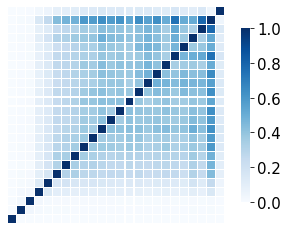

In [118]:
df = pd.DataFrame(label_freq_freq_2d_map_norm[0].numpy())
mask = np.zeros_like(label_freq_freq_2d_map_norm[0])
mask[np.tril_indices_from(mask)] = True
_ = sb.heatmap(df, cmap="Blues", square=True, linewidth=0.1, cbar_kws={"shrink": .8}, 
               vmin=0.0)
plt.ylim(0, 24)
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text yticklabel objects>)

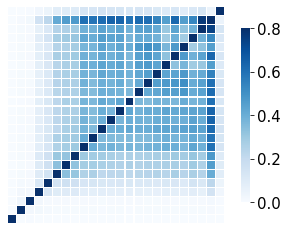

In [119]:
df = pd.DataFrame(label_freq_freq_2d_map_norm[1].numpy())
_ = sb.heatmap(df, cmap="Blues", square=True, linewidth=0.1, cbar_kws={"shrink": .8},
               vmin=0.0, vmax=0.8)
plt.ylim(0, 24)
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text yticklabel objects>)

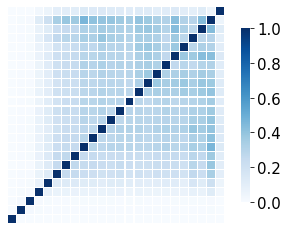

In [120]:
df = pd.DataFrame(label_freq_freq_2d_map_norm[2].numpy())
_ = sb.heatmap(df, cmap="Blues", square=True, linewidth=0.1, cbar_kws={"shrink": .8},
               vmin=0.0)
plt.ylim(0, 24)
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text yticklabel objects>)

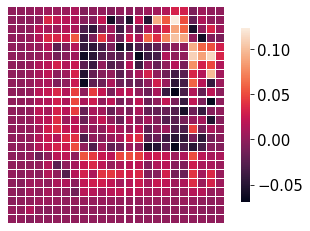

In [130]:
df = pd.DataFrame((label_freq_freq_2d_map_norm[0]-label_freq_freq_2d_map_norm[1]).numpy())
_ = sb.heatmap(df, square=True, linewidth=0.1, cbar_kws={"shrink": .8})
plt.ylim(0, 24)
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text yticklabel objects>)

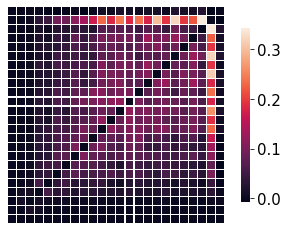

In [131]:
df = pd.DataFrame((label_freq_freq_2d_map_norm[0]-label_freq_freq_2d_map_norm[2]).numpy())
_ = sb.heatmap(df, square=True, linewidth=0.1, cbar_kws={"shrink": .8})
plt.ylim(0, 24)
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text yticklabel objects>)

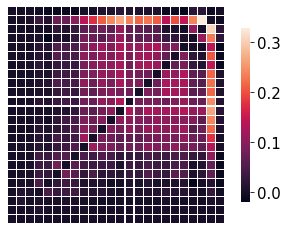

In [132]:
df = pd.DataFrame((label_freq_freq_2d_map_norm[1]-label_freq_freq_2d_map_norm[2]).numpy())
_ = sb.heatmap(df, square=True, linewidth=0.1, cbar_kws={"shrink": .8})
plt.ylim(0, 24)
plt.xticks([])
plt.yticks([])

#### Running BERT sentence embeddings and 2nd order frequency information

In [38]:
from models.modeling_bert import CustomerizedBertForSequenceClassification
NUM_LABELS = 3
MAX_SEQ_LEN = 128
CACHE_DIR = "../tmp/"
MODEL_TYPE = "bert-base-uncased"
MODEL_PATH = "../saved-models/sst-tenary-finetuned-bert-base-uncased-3B/pytorch_model.bin"
NUM_LABEL_CONFIG = {
    "sst2": 2,
    "sst3": 3
}
config = AutoConfig.from_pretrained(
    MODEL_TYPE,
    num_labels=NUM_LABEL_CONFIG[task_name],
    finetuning_task=task_name,
    cache_dir=CACHE_DIR
)
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_TYPE,
    use_fast=False,
    cache_dir=CACHE_DIR
)
model = CustomerizedBertForSequenceClassification.from_pretrained(
    MODEL_PATH,
    from_tf=False,
    config=config,
    cache_dir=CACHE_DIR
)
SAMPLE_LIMIT=1000
train_df = train_df.shuffle(seed=seed)
train_df_subset = train_df.select(range(SAMPLE_LIMIT))
TASK_CONFIG = {
    "sst3": ("text", None)
}
sentence1_key, sentence2_key = TASK_CONFIG[task_name]
padding = "max_length"
label_to_id = None
def preprocess_function(examples):
    # Tokenize the texts
    args = (
        (examples[sentence1_key],) if sentence2_key is None else (examples[sentence1_key], examples[sentence2_key])
    )
    result = tokenizer(*args, padding=padding, max_length=MAX_SEQ_LEN, truncation=True)
    # Map labels to IDs (not necessary for GLUE tasks)
    if label_to_id is not None and "label" in examples:
        result["label"] = [label_to_id[l] for l in examples["label"]]
    return result
train_df_subset = train_df_subset.map(preprocess_function, batched=True)

In [43]:
from torch.utils.data import DataLoader
subset_dataloader = DataLoader(train_df_subset, 1, shuffle=True)

In [49]:
model.eval()
for i, batch_dataloader in enumerate(tqdm(subset_dataloader)):
    input_ids = torch.cat(batch_dataloader['input_ids'], dim=0).unsqueeze(dim=0)
    attention_mask = torch.cat(batch_dataloader['attention_mask'], dim=0).unsqueeze(dim=0)
    hidden_states = model.forward_simple(input_ids=input_ids, attention_mask=attention_mask)

  0%|          | 1/1000 [00:38<10:33:31, 38.05s/it]


KeyboardInterrupt: 